In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parâmetros
u0   = 4*np.pi*1e-7 #.. H/m
urFe = 2500*u0 #....... H/m
urAr =    1*u0 #....... H/m
dx   = 1e-2 #............ m
l    = 0.22 #............ m
h    = 0.20 #............ m
lbd  = 1.75 #     lambda, sobrerrelaxação
tol  = 1e-4 # tolerância, sobrerrelaxação

def gera_grid(dx, l, h):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid

    Returns
    -------
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1

    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)
    Y = np.around(Y, decimals=10)
    X = np.around(X, decimals=10)


    return M, N, X, Y, grid

def define_elementos(X, Y, grid):
    '''
    Função que toma o `grid`, gerado pelo método `gera_grid()` e o completa
    com a identificação dos elementos que o compõe cada qual em sua posição

    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco

    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina_LE
    - 5: bobina_LD
    - 6: interfaces Ar->Fe em x
    - 7: interfaces Ar->Fe em y
    - 8: interfaces Fe->Ar em x
    - 9: interfaces Fe->Ar em y
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    # definindo as regiões dos diferentes elementos
    armadura = (X < 0.04)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 0.04, X < 0.05),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 0.05, X <= 0.14),
            np.logical_and(Y > -0.06, Y < 0.06)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X > 0.05, X < 0.20),
            np.logical_or(Y < -0.06, Y > 0.06)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 0.16, X < 0.20)
        )

    bobina_LE =  np.logical_and(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(X > 0.14, X < 0.16),
        np.logical_and(Y > -0.06, Y <  0.06)
        )
    
    bobina_LD = np.logical_and(
        # bobina da direita (corrente saindo da folha)
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(X > 0.20, X < 0.22),
        np.logical_and(Y > -0.06, Y <  0.06)
        )
    
    Ar_Fe_x = np.logical_or(
        # interfaces Ar-> Fe na direção x
        # pontas do núcleo (em cima e em baixo)
        np.logical_and(
            X == 0.05,
            np.logical_or(
                Y <= -0.06, Y >= 0.06
            )
        ),
        # bobina_LE e núcleo
        np.logical_and(
            X == 0.16,
            np.logical_and(
                Y >= -0.06, Y <= 0.06
            )
        
        )
    )
    
    Ar_Fe_y = np.logical_and(
        # interfaces Ar-> Fe na direção y
        # entreferro e bobina LE -> núcleo em baixo
        np.logical_and(
            X >= 0.05, X <= 0.16        
        ),
        Y == -0.06    
    )
    
    Fe_Ar_x = np.logical_or(
        # interfaces Fe-> Ar na direção x
        # armadura e entreferro
        (X==0.04),
        # núcleo e bobina LD
        np.logical_and(
            (X == 0.20),
            np.logical_and(
                Y >= -0.06, Y <= 0.06
            )
        )
    )
    
    Fe_Ar_y = np.logical_and(
        # interfaces Fe-> Ar na direção y
        # núcleo -> bobina LE e entreferro em cima
        np.logical_and(
            X >= 0.05, X <= 0.16
        ),
        (Y == 0.06)
    )

    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro]    = 1
    grid[armadura]      = 2
    grid[nucleo]        = 3
    grid[bobina_LE]     = 4
    grid[bobina_LD]     = 5
    grid[Ar_Fe_x]       = 6
    grid[Ar_Fe_y]       = 7
    grid[Fe_Ar_x]       = 8
    grid[Fe_Ar_y]       = 9
    
    return grid

M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
A = np.zeros((N, M))

def calcula_J(y):
    '''
    Função auxiliar que calcula a corrente dado um ponto y
    '''
    return 2e6*np.cos(np.pi*y/12e-2) + 8e5

def itera_A(A, grid, N, M, Y):
    A_ = A.copy()
    for j in range(1, N-1):
        for i in range(1, M-1):
            if grid[j, i] == 0:
                A_[j, i] = 0
            elif grid[j, i] in [1, 2, 3]:
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1])
            elif grid[j, i] == 4:
                y = Y[j, 0]
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1]
                               + dx**2*urAr*calcula_J(y))
            # na bobina e na interface entreferro-bobina
            elif grid[j, i] == 5:
                y = Y[j, 0]
                A_[j, i] = 1/4 * (A[j+1, i] 
                               + A[j-1, i]
                               + A[j, i-1]
                               + A[j, i+1]
                               - dx**2*urAr*calcula_J(y))
            elif grid[j, i] == 6:
                uAntes  = urAr
                uDepois = urFe
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (alfa*(A[j + 1, i] + A[j - 1, i])
                                      + 2*(A[j, i + 1] + (alfa - 1)*A[j, i - 1]))

            elif grid[j, i] == 7:
                uAntes  = urAr
                uDepois = urFe
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (2*(A[j + 1, i] + (alfa - 1)*A[j - 1, i])
                                       + alfa*(A[j, i + 1] + A[j, i - 1]))

            elif grid[j, i] == 8:
                uAntes  = urFe
                uDepois = urAr
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (alfa*(A[j + 1, i] + A[j - 1, i])
                                      + 2*(A[j, i + 1] + (alfa - 1)*A[j, i - 1]))

            elif grid[j, i] == 9:
                uAntes  = urFe
                uDepois = urAr
                alfa = 1 + uDepois/uAntes
                A_[j, i] = 1/(4*alfa) * (2*(A[j + 1, i] + (alfa - 1)*A[j - 1, i])
                                       + alfa*(A[j, i + 1] + A[j, i - 1]))
    
    aplica_cc(A_, grid)
    return A_

def aplica_cc(A, grid):
    '''
    Função que aplica as condições de contorno em A, o que inclui
    as condições de Dirichlet (potencial na fronteira externa constante
    e igual a 0) e também zera o potencial para os pontos do grid que
    "não pertencem" ao problema (pontos que foram anexados para tornar)
    o grid regular, mas que não fazem parte do problema
    '''
    # bordas com potencial nulo
    A[ 0,  :] = 0
    A[-1,  :] = 0
    A[ :,  0] = 0
    A[ :, -1] = 0
    # zera partes que não pertencem ao problema
    A         = np.where(grid==0, 0, A)

def dif_central(A, i, j, dx, variavel=True):
    """
    Calcula a derivada parcial, por meio da diferença central em relação a variável 
    dada uma matriz A e o ponto (i, j) do qual se deseja a derivada.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    variavel: Bool, default = True
        para qual variável se deseja calcular a derivada parcial.
        Se for True equivale a variável é x e se False a variável
        é y.
    
    Returns
    -------
    delA_delvariavel: float
        valor da derivada parcial calculada em relação a variável desejada
    """
    if variavel:
        #se calcula a derivada parcial em relação a x
        delA_delvariavel = (A[j-1, i] + A[j+1, i])/(2*dx)
    else:
        #se calcula a derivada parcial em relação a y
        delA_delvariavel = (A[j, i-1] + A[j, i+1])/(2*dx)
    return delA_delvariavel

def dif_progressiva(A, i, j, dx, variavel=True):
    """
    Calcula a derivada parcial, por meio da diferença progressiva de 3 pontos 
    em relação a variável  dada uma matriz A e o ponto (i, j) do qual se 
    deseja a derivada.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    variavel: Bool, default = True
        para qual variável se deseja calcular a derivada parcial.
        Se for True equivale a variável é x e se False a variável
        é y.
    
    Returns
    -------
    delA_delvariavel: float
        valor da derivada parcial calculada em relação a variável desejada
    """
    if variavel:
        #se calcula a derivada parcial em relação a x
        delA_delvariavel = (-A[j+2, i] + 4*A[j+1, i]-3*A[j, i])/(2*dx)
    else:
        #se calcula a derivada parcial em relação a y
        delA_delvariavel = (-A[j, i+2] + 4*A[j, i+1]-3*A[j, i])/(2*dx)
    return delA_delvariavel


def dif_regressiva(A, i, j, dx, variavel=True):
    """
    Calcula a derivada parcial, por meio da diferença regressiva de 3 pontos 
    em relação a variável  dada uma matriz A e o ponto (i, j) do qual se 
    deseja a derivada.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    i: int
        linha da qual se deseja calcular
    j: int
        coluna da qual se deseja calcular
    dx: float
        passo
    variavel: Bool, default = True
        para qual variável se deseja calcular a derivada parcial.
        Se for True equivale a variável é x e se False a variável
        é y.
    
    Returns
    -------
    delA_delvariavel: float
        valor da derivada parcial calculada em relação a variável desejada
    """
    if variavel:
        #se calcula a derivada parcial em relação a x
        delA_delvariavel = (A[j+2, i] - 4*A[j+1, i]+3*A[j, i])/(2*dx)
    else:
        #se calcula a derivada parcial em relação a y
        delA_delvariavel = (A[j, i+2] - 4*A[j, i+1]+3*A[j, i])/(2*dx)
    return delA_delvariavel

def calcula_B(A, N, M):
    """
    Calcula o vetor B ponto a ponto e retorna um array que são as
    componentes em x e outro que são as componentes em y.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    
    Returns
    -------
    Bx: np.ndarray, dim=(N, M)
        matriz das componentes de Bx
    By: np.ndarray, dim=(N, M)
        matriz das componentes de By
    """
    Bx = A.copy()
    By = A.copy()
    for j in range(1, N-1):
        for i in range(1, M-1):
            delA_delx = dif_central(A, i, j, dx, variavel=True)
            delA_dely = dif_central(A, i, j, dx, variavel=False)
            Bx[j, i] = delA_delx
            By[j, i] = delA_dely
    
    return Bx, By

In [3]:
Anew = itera_A(A, grid, N, M, Y)
erro = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew, dtype=float), where=Anew!=0)))
print(f"{erro}")
i = 0
while erro > tol and i <500:
    aux = Anew
    Anew = lbd*itera_A(Anew, grid, N, M, Y) + (1 - lbd)*A
    A    = aux
    erro    = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew, dtype=float), where=Anew!=0)))
    i+= 1
    if i%250==0:
        print(f"{i}, {erro}")

1.0


In [103]:
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)

In [225]:
A/Anew

<ipython-input-225-6a524ae8218c>:1: RuntimeWarning: invalid value encountered in true_divide
  A/Anew


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [222]:
np.max(Anew)

0.000263380519720466

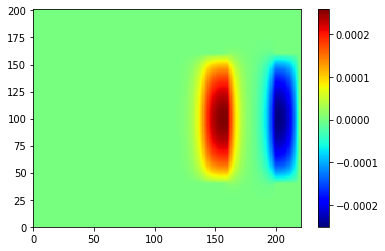

In [230]:
plt.pcolor(A, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

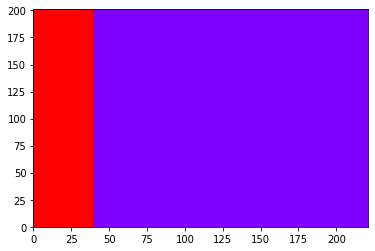

In [116]:
plt.pcolor(grid==2, cmap=plt.cm.rainbow)


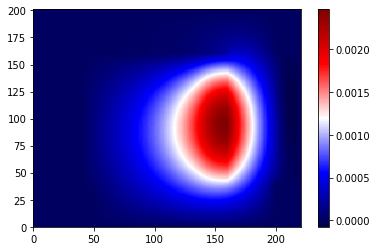

In [83]:
plt.pcolor(A, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

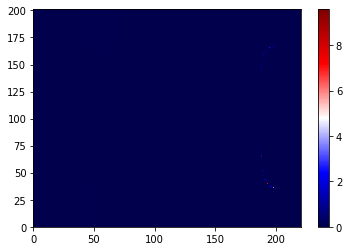

In [75]:
plt.pcolor(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)), cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

In [24]:
A_ = itera_A(A_, grid, N, M, Y)

In [44]:
erro

0.002984255911704369

In [32]:
np.max(np.abs(np.divide(A_ - A, A_, out=np.zeros_like(A), where=A!=0)))

0.0

In [35]:
np.divide(A_ - A, A_, out=np.zeros_like(A), where=A!=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

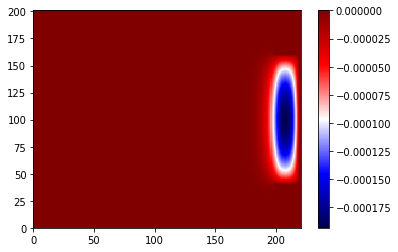

In [56]:
plt.pcolor(Anew, cmap=plt.cm.seismic)
plt.colorbar()
plt.show()

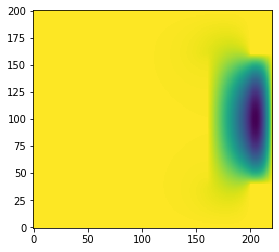

In [50]:
plt.imshow(Anew, origin='lower', interpolation="none")

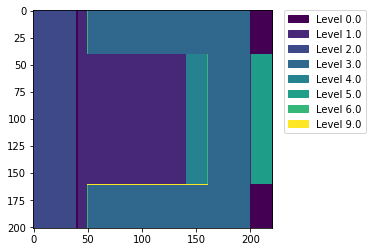

In [87]:
import matplotlib.patches as mpatches
values = np.unique(grid.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(grid, interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()
#plt.imshow(grid, origin='lower', interpolation="none")
